In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ExponentialLR


import time


In [114]:
df = pd.read_csv("../data/tesla_stock.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [115]:
X = df.get('Close').values
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape((-1,1 ))).reshape((-1))

split_index = 1400
print(X.shape)
X_train, X_test = X[:split_index], X[split_index:] #train_test_split(X, test_size=0.1, shuffle=False)
timesteps_count = 30

def get_train_test():
    x_train, y_train, x_test, y_test = [], [], [], []

    i = 0
    while i+timesteps_count<len(X_train):
        x_train.append(X_train[i:i+timesteps_count])
        y_train.append(X_train[i+timesteps_count])
        i+=1

    i=0
    while i+timesteps_count<len(X_test):
        x_test.append(X_test[i:i+timesteps_count])
        y_test.append(X_test[i+timesteps_count])
        i+=1
        
    x_train, y_train = torch.tensor(np.array(x_train), dtype=torch.float), torch.tensor(np.array(y_train), dtype=torch.float)
    x_test, y_test = torch.tensor(np.array(x_test), dtype=torch.float), torch.tensor(np.array(y_test), dtype=torch.float)
    return x_train, y_train, x_test, y_test
x_train, y_train, x_test, y_test = get_train_test()
print(x_train.shape, y_train.shape)

(1692,)
torch.Size([1370, 30]) torch.Size([1370])


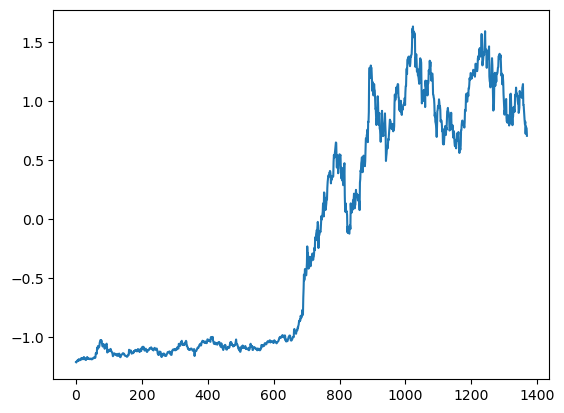

In [116]:
plt.plot(y_train)

## Develop an LSTM network

In [128]:
MAX_TIME = 50

In [118]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):

        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, num_layers=1)

        self.linear1 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = x
        # if len(x.shape)==2:
        #     out = x.view((-1, 1, self.input_dim))
        out,_ = self.lstm1(out)
        out = self.linear1(out)
        #out = self.linear2(out)
        out = out.view((-1, ))
        return out


class LinearPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):

        super(LinearPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out = x
        # if len(x.shape)==2:
        #     out = x.view((-1, 1, self.input_dim))
        out = self.linear1(out)
        out = nn.ReLU()(out)
        out = self.linear2(out)
        out = out.view((-1, ))
        return out




 85%|████████▍ | 8470/10000 [2:46:40<30:06,  1.18s/it]


Text(0.5, 1.0, 'Train')

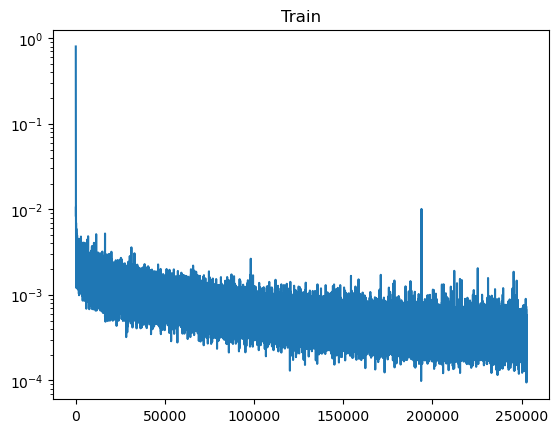

In [119]:
model = LSTMPredictor(x_train.shape[1], hidden_dim = 10)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.999)
EPOCHS = 10
BATCH_SIZE = 256
N = x_train.shape[0]
losses = []
t0 = time.time()
t1 = time.time()
with tqdm(total=MAX_TIME) as pbar:
    while time.time()<t0+MAX_TIME:
        if time.time()>t1+1:
            t1 = time.time()
            pbar.update()
        indices = np.arange(len(x_train))
        np.random.shuffle(indices)
        x_train = x_train[indices]
        y_train = y_train[indices]
        #print(indices.shape)
        for i in range(N//BATCH_SIZE+1):
            model.zero_grad()
            batch_x = x_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            batch_y = y_train[i*BATCH_SIZE: (i+1)*BATCH_SIZE]
            output = model(batch_x)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()

            losses.append(loss.detach().numpy())
        scheduler.step

 
plt.semilogy(losses)
plt.title("Train")

tensor(96.0724, dtype=torch.float64)


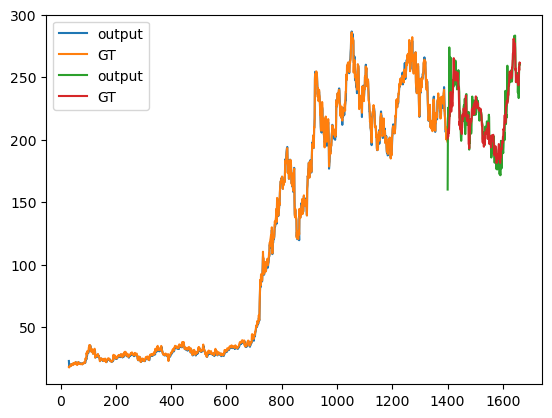

In [120]:
def test(model):
    with torch.no_grad():
        
        output = model(x_test)
        unscaled_output = scaler.inverse_transform(output.reshape((-1, 1))).reshape((-1, ))
        unscaled_y_test = scaler.inverse_transform(y_test.reshape((-1, 1))).reshape((-1,))

        output = model(x_train)

        unscaled_output_train = scaler.inverse_transform(output.reshape((-1, 1))).reshape((-1, ))
        unscaled_y_train = scaler.inverse_transform(y_train.reshape((-1, 1))).reshape((-1,))


        loss = loss_fn(torch.tensor(unscaled_output),torch.tensor(unscaled_y_test ))
        plt.figure()
        #print(unscaled_output_train.shape)
        plt.plot(np.arange(timesteps_count, split_index), unscaled_output_train, label="output")
        plt.plot(np.arange(timesteps_count, split_index), unscaled_y_train, label="GT")
        
        plt.plot(np.arange(split_index, split_index+len(x_test)), unscaled_output, label="output")
        plt.plot(np.arange(split_index, split_index+len(x_test)), unscaled_y_test, label="GT")
        plt.legend()
        print(loss)
x_train, y_train, x_test, y_test = get_train_test()

test(model)

## Predicting with moving average

In [121]:
window_size = 50
df["MA"] = df["Close"].rolling(window_size).mean()

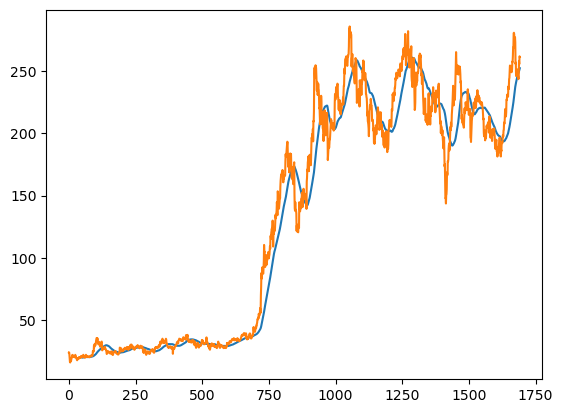

In [122]:
plt.plot(df["MA"])
plt.plot(df["Close"])

## Prediction with exponential average

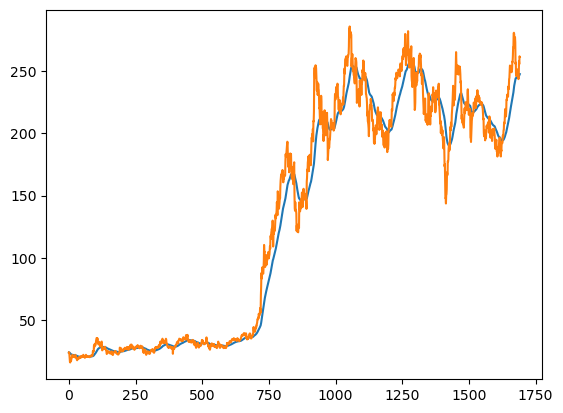

In [123]:
df["EA"] = df["Close"].ewm(span=window_size, adjust=False).mean()
plt.plot(df["EA"])
plt.plot(df["Close"])


In [247]:
%load_ext autoreload

%autoreload 2

from functions.PyTorchGN import NN_GN
from algorithms.algo2 import optimize

x_train, y_train, x_test, y_test = get_train_test()

y_train = y_train.reshape((-1, 1)).detach().numpy()
x_train = x_train.detach().numpy()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [248]:
input_dim, hidden_dim = x_train.shape[1], 10
model = LSTMPredictor(input_dim, hidden_dim)

input_dim, hidden_dim = x_train.shape[1], 60

model = LinearPredictor(input_dim, hidden_dim)
nn_gn = NN_GN(model, is_linear=False)
X0 = nn_gn.get_X()


print(x_train.shape, y_train.shape, X0.shape)
## Do Gauss Newton

X_est,losses_gn_backtrack, _ = optimize(nn_gn, X0, x_train, y_train, steps=300,batch_size=300 ,
max_time=MAX_TIME,backtrack=True,optimization_method="Random", lambd=0.001)
plt.semilogy(losses)

param 4
param 4
(1370, 30) (1370, 1) (1921,)
Parameter count 1921


  0%|          | 0/300 [00:00<?, ?it/s]

a (30,)
1
tensor(-0.1451, grad_fn=<UnbindBackward0>)
4
row (1800,)
jac (1, 1800)


ValueError: could not broadcast input array from shape (1,1800) into shape (1,1921)

tensor(752.6119, dtype=torch.float64)


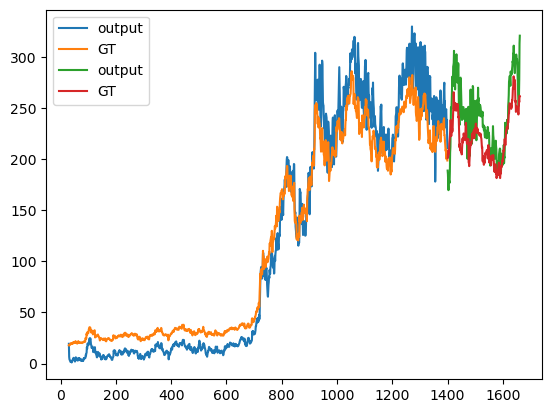

In [ ]:
x_train, y_train, x_test, y_test = get_train_test()


test(model)

In [127]:
model(x_train)

tensor([-1.1939, -1.8213, -2.1980,  ...,  1.7790,  1.7839,  1.8026],
       grad_fn=<ViewBackward0>)